### Классификация: превышает ли значение IC50 медианное значение выборки

In [8]:
import numpy as np
import pandas as pd
import dtale

In [2]:
df_scaled = pd.read_csv('df_scaled.csv')

In [3]:
df_scaled.shape

(969, 188)

In [4]:
df_scaled.head()

,IC50,CC50,SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.599333,-0.648886,0.023693,-1.766931,-1.766931,1.230105,0.859969,-0.751719,1.076111,0.260487,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
1,-0.623447,-0.917447,-0.258103,-2.112017,-2.112017,2.098636,0.953566,-0.540135,1.257528,0.292155,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
2,0.360199,-0.671529,-0.341875,-2.518530,-2.518530,2.154087,0.959542,-1.485466,1.017293,0.748665,...,6.379466,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
3,-0.619328,-0.755671,0.492044,-1.765937,-1.765937,1.250111,0.862125,-0.937063,0.991464,0.370656,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,3.080565,-0.085302
4,-0.154375,-0.706065,-0.334138,-1.749744,-1.749744,0.538633,0.785453,-0.696952,0.567012,0.905000,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,-0.169372,-0.085302


### Сравнены различные модели с настройкой гиперпараметров, сделаны выводы о применимости методов, даны рекомендации по улучшению.

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import optuna

# Загрузка данных
# df_scaled - DataFrame, содержащий данные, в том числе 'IC50'
y = df_scaled['IC50']  # Целевая переменная
median_ic50 = y.median()
y_binary = (y > median_ic50).astype(int)  # Бинарная целевая переменная
X = df_scaled.drop(columns=['SI', 'CC50', 'IC50'])  # Признаки

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)

# Словарь классификаторов для оптимизации
CLASSIFIERS = {
    'XGBClassifier': XGBClassifier,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'RandomForestClassifier': RandomForestClassifier,
    'CatBoostClassifier': CatBoostClassifier
}

# Функция для объектов обработки с использованием Optuna
def objective(trial, classifier_name):
    # Определяем параметры для каждого классификатора
    if classifier_name == 'XGBClassifier':
        params = {
            'objective': 'binary:logistic',
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        model = XGBClassifier(**params)
    
    elif classifier_name == 'DecisionTreeClassifier':
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = DecisionTreeClassifier(**params)

    elif classifier_name == 'RandomForestClassifier':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = RandomForestClassifier(**params)

    elif classifier_name == 'CatBoostClassifier':
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'depth': trial.suggest_int('depth', 1, 10),
            'iterations': trial.suggest_int('iterations', 50, 550),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
            'verbose': 0  # Отключаем вывод информации о процессе обучения
        }
        model = CatBoostClassifier(**params)

    # Обучение модели
    model.fit(X_train, y_train)

    # Прогнозирование на тестовой выборке
    y_pred = model.predict(X_test)

    # Оценка модели
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy  # Возвращаем accuracy для оптимизации

# Оптимизация гиперпараметров для каждого классификатора
best_models = {}
for classifier_name in CLASSIFIERS.keys():
    print(f"Оптимизация гиперпараметров для {classifier_name}...")
    study = optuna.create_study(direction='maximize')  # Максимизируем accuracy
    study.optimize(lambda trial: objective(trial, classifier_name), n_trials=200)  # Число итераций оптимизации

    # Сохранение наилучших параметров и модели
    best_models[classifier_name] = {
        'best_params': study.best_params,
        'best_model': CLASSIFIERS[classifier_name](**study.best_params).fit(X_train, y_train)
    }

    print(f"Оптимальные гиперпараметры для {classifier_name}:", study.best_params)

# Оценка всех моделей на тестовой выборке
for classifier_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    print(f"{classifier_name} - Тестовая точность: {accuracy}, Тестовый F1-score: {f1}")


[I 2025-05-24 12:26:50,995] A new study created in memory with name: no-name-8384ee69-8914-4d6b-bd7b-5b512186155d


Оптимизация гиперпараметров для XGBClassifier...


[I 2025-05-24 12:26:51,587] Trial 0 finished with value: 0.6597938144329897 and parameters: {'learning_rate': 0.036421574078243174, 'max_depth': 3, 'n_estimators': 506, 'subsample': 0.5248314613770221, 'colsample_bytree': 0.7181987725604353}. Best is trial 0 with value: 0.6597938144329897.
[I 2025-05-24 12:26:52,173] Trial 1 finished with value: 0.6804123711340206 and parameters: {'learning_rate': 0.41940661544238866, 'max_depth': 11, 'n_estimators': 360, 'subsample': 0.8433370261829689, 'colsample_bytree': 0.9026037454781923}. Best is trial 1 with value: 0.6804123711340206.
[I 2025-05-24 12:26:52,597] Trial 2 finished with value: 0.5670103092783505 and parameters: {'learning_rate': 0.00014222292444946536, 'max_depth': 5, 'n_estimators': 251, 'subsample': 0.8560818617414712, 'colsample_bytree': 0.7803664848165441}. Best is trial 1 with value: 0.6804123711340206.
[I 2025-05-24 12:26:53,446] Trial 3 finished with value: 0.6666666666666666 and parameters: {'learning_rate': 0.0061086688031

Оптимальные гиперпараметры для XGBClassifier: {'learning_rate': 0.011124137090971143, 'max_depth': 10, 'n_estimators': 360, 'subsample': 0.9257391038461964, 'colsample_bytree': 0.9876962953268836}
Оптимизация гиперпараметров для DecisionTreeClassifier...


[I 2025-05-24 12:30:32,411] Trial 7 finished with value: 0.5910652920962199 and parameters: {'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.6219931271477663.
[I 2025-05-24 12:30:32,434] Trial 8 finished with value: 0.5979381443298969 and parameters: {'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.6219931271477663.
[I 2025-05-24 12:30:32,462] Trial 9 finished with value: 0.5876288659793815 and parameters: {'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6219931271477663.
[I 2025-05-24 12:30:32,491] Trial 10 finished with value: 0.5979381443298969 and parameters: {'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6219931271477663.
[I 2025-05-24 12:30:32,527] Trial 11 finished with value: 0.6288659793814433 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 11 

Оптимальные гиперпараметры для DecisionTreeClassifier: {'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1}
Оптимизация гиперпараметров для RandomForestClassifier...


[I 2025-05-24 12:30:39,750] Trial 0 finished with value: 0.6357388316151202 and parameters: {'n_estimators': 458, 'max_depth': 1, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.6357388316151202.
[I 2025-05-24 12:30:39,853] Trial 1 finished with value: 0.6632302405498282 and parameters: {'n_estimators': 57, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.6632302405498282.
[I 2025-05-24 12:30:40,241] Trial 2 finished with value: 0.6769759450171822 and parameters: {'n_estimators': 198, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.6769759450171822.
[I 2025-05-24 12:30:40,907] Trial 3 finished with value: 0.6804123711340206 and parameters: {'n_estimators': 412, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.6804123711340206.
[I 2025-05-24 12:30:41,100] Trial 4 finished with value: 0.6735395189003437 and parameters: {'n

Оптимальные гиперпараметры для RandomForestClassifier: {'n_estimators': 362, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1}
Оптимизация гиперпараметров для CatBoostClassifier...


[I 2025-05-24 12:32:47,444] Trial 0 finished with value: 0.6872852233676976 and parameters: {'learning_rate': 0.049944375413911224, 'depth': 3, 'iterations': 354, 'l2_leaf_reg': 0.00045765552022915425}. Best is trial 0 with value: 0.6872852233676976.
[I 2025-05-24 12:32:49,932] Trial 1 finished with value: 0.6357388316151202 and parameters: {'learning_rate': 0.6821656211129895, 'depth': 7, 'iterations': 289, 'l2_leaf_reg': 0.00030210748876179593}. Best is trial 0 with value: 0.6872852233676976.
[I 2025-05-24 12:32:50,590] Trial 2 finished with value: 0.6460481099656358 and parameters: {'learning_rate': 0.0027753993891271845, 'depth': 2, 'iterations': 526, 'l2_leaf_reg': 0.006821758137738271}. Best is trial 0 with value: 0.6872852233676976.
[I 2025-05-24 12:32:51,495] Trial 3 finished with value: 0.6597938144329897 and parameters: {'learning_rate': 0.0005788834928011292, 'depth': 7, 'iterations': 98, 'l2_leaf_reg': 0.0002496780847950143}. Best is trial 0 with value: 0.6872852233676976.


0:	learn: 0.6907660	total: 18.1ms	remaining: 5.98s
1:	learn: 0.6880589	total: 35.4ms	remaining: 5.83s
2:	learn: 0.6858697	total: 53.3ms	remaining: 5.84s
3:	learn: 0.6833237	total: 70.9ms	remaining: 5.81s
4:	learn: 0.6815543	total: 88.4ms	remaining: 5.78s
5:	learn: 0.6796172	total: 106ms	remaining: 5.76s
6:	learn: 0.6771763	total: 123ms	remaining: 5.71s
7:	learn: 0.6756393	total: 141ms	remaining: 5.69s
8:	learn: 0.6739822	total: 158ms	remaining: 5.66s
9:	learn: 0.6717043	total: 176ms	remaining: 5.66s
10:	learn: 0.6692426	total: 193ms	remaining: 5.63s
11:	learn: 0.6679181	total: 211ms	remaining: 5.63s
12:	learn: 0.6656043	total: 229ms	remaining: 5.62s
13:	learn: 0.6638900	total: 247ms	remaining: 5.6s
14:	learn: 0.6621676	total: 264ms	remaining: 5.59s
15:	learn: 0.6607134	total: 282ms	remaining: 5.57s
16:	learn: 0.6582705	total: 300ms	remaining: 5.56s
17:	learn: 0.6565227	total: 317ms	remaining: 5.54s
18:	learn: 0.6549570	total: 335ms	remaining: 5.52s
19:	learn: 0.6522827	total: 352ms	rem

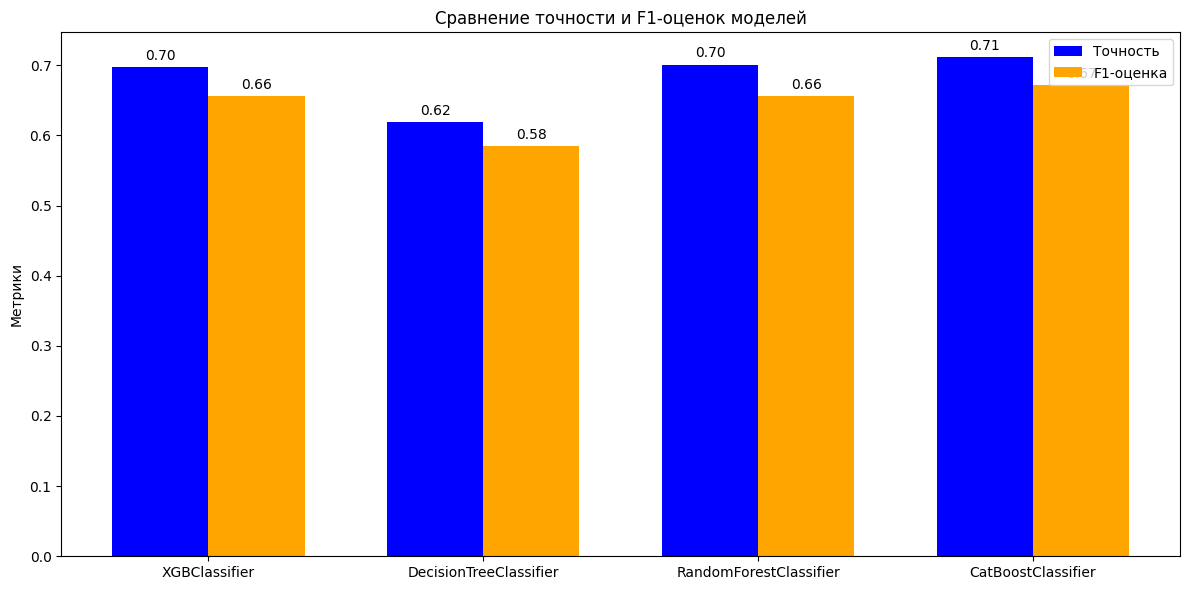

In [6]:
# Визуализация результатов
import matplotlib.pyplot as plt

# Сбор данных для визуализации
models_names = list(best_models.keys())
accuracies = []
f1_scores = []

# Заполнение массивов оценками каждой модели
for classifier_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    accuracies.append(accuracy)
    f1_scores.append(f1)

# Визуализация результатов
x = np.arange(len(models_names))  # метки для оси x
width = 0.35  # ширина столбцов

fig, ax = plt.subplots(figsize=(12, 6))

# Построение столбчатых диаграмм для точности и F1-оценок
bars1 = ax.bar(x - width/2, accuracies, width, label='Точность', color='blue')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1-оценка', color='orange')

# Настройка отметок оси x и заголовка
ax.set_ylabel('Метрики')
ax.set_title('Сравнение точности и F1-оценок моделей')
ax.set_xticks(x)
ax.set_xticklabels(models_names)
ax.legend()

# Добавление значений над столбцами
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # Отодвигаем значение немного вверх
                    textcoords="offset points", 
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

# Отображение графика
plt.tight_layout()
plt.show()

*На основе представленных результатов тестовых метрик для различных классификаторов можно сделать следующие выводы:*

- *CatBoostClassifier:*
- Тестовая точность: 0.711
- Тестовый F1-score: 0.672
- Показал наилучшие результаты среди всех классификаторов как по тестовой точности, так и по F1-score. Это свидетельствует о его хорошей способности к классификации.
- *RandomForestClassifier:*
- Тестовая точность: 0.701
- Тестовый F1-score: 0.656
- Второй по эффективности. Несмотря на то, что точность немного ниже, F1-score близок к XGBClassifier.
- *XGBClassifier:*
- Тестовая точность: 0.698
- Тестовый F1-score: 0.656
- Результаты сопоставимы с RandomForestClassifier, однако он немного уступает по точности.
- *DecisionTreeClassifier:*
- Тестовая точность: 0.619
- Тестовый F1-score: 0.584
- Наименее эффективный классификатор из представленных. Значительно ниже точность и F1-score по сравнению с другими методами.
*Общие выводы:*
- CatBoostClassifier явно выделяется среди остальных алгоритмов, демонстрируя наилучшие результаты.
- RandomForestClassifier и XGBClassifier показывают сравнимые результаты, хоть и уступают CatBoost.
- DecisionTreeClassifier следует рассматривать с осторожностью, поскольку его показатели значительно ниже, что может указывать на переобучение или недостаточную сложность модели.
- Рекомендуется использовать CatBoostClassifier в дальнейших исследованиях и выборах моделей, учитывая его лучшие аналитические показатели.

*Данный код демонстрирует процесс сохранения и загрузки обученных моделей машинного обучения с использованием библиотеки `pickle` в Python.*

In [7]:
import pickle
from sklearn.metrics import mean_squared_error, r2_score

# Функция для сохранения модели
def save_model(model, model_name):
    filename = f"{model_name}_IC50.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
        print(f"Модель '{filename}' сохранена.")

# Функция для загрузки модели
def load_model(model_name):
    filename = f"{model_name}_IC50.pkl"
    try:
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        print(f"Модель '{filename}' загружена.")
        return model
    except FileNotFoundError:
        print(f"Ошибка: файл '{filename}' не найден.")
        return None

# Сохранение обученных моделей
for classifier_name, model_data in best_models.items():
    save_model(model_data['best_model'], classifier_name)

# Загрузка моделей для использования
loaded_models = {
    'XGBClassifier': load_model('XGBClassifier'),
    'DecisionTreeClassifier': load_model('DecisionTreeClassifier'),
    'RandomForestClassifier': load_model('RandomForestClassifier'),
    'CatBoostClassifier': load_model('CatBoostClassifier')
}


Модель 'XGBClassifier_IC50.pkl' сохранена.
Модель 'DecisionTreeClassifier_IC50.pkl' сохранена.
Модель 'RandomForestClassifier_IC50.pkl' сохранена.
Модель 'CatBoostClassifier_IC50.pkl' сохранена.
Модель 'XGBClassifier_IC50.pkl' загружена.
Модель 'DecisionTreeClassifier_IC50.pkl' загружена.
Модель 'RandomForestClassifier_IC50.pkl' загружена.
Модель 'CatBoostClassifier_IC50.pkl' загружена.
